# Dense Email Network
Link: https://snap.stanford.edu/data/email-Eu-core.html
> Dense email network from a European research institution.

---

Focus: explore the differences between models and correctly apply the right one

In [2]:
# Imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
import sys
sys.path.append('../')
from utils import negative_sampling as ns, splits, plot


In [3]:
# Const
dataset = "data/email-Eu-core.txt"
random.seed(42)

In [4]:
# Graph Creation
G = nx.read_edgelist(dataset, nodetype=int)

## Exploratory Data Analysis (EDA)

In [5]:
density = nx.density(G)

print(G)
print(f'Average degree: {sum(dict(G.degree).values()) / len(G.nodes):.1f}')
print(f'Max degree: {max(dict(G.degree).values())}')
print(f'Min degree: {min(dict(G.degree).values())}')
print(f'Density: {density:.4f}')

Graph with 1005 nodes and 16706 edges
Average degree: 33.2
Max degree: 347
Min degree: 1
Density: 0.0331


---

In [6]:
# Connected Components
print("Number of connected components:", nx.number_connected_components(G))

G_lcc = G.subgraph(max(nx.connected_components(G), key=len)).copy()
print("Largest Connected Component:", G_lcc)

Number of connected components: 20
Largest Connected Component: Graph with 986 nodes and 16687 edges


The LCC is almost the size of the entire network, confirming the fact that it's a dense, small-world network. We'll work with the LCC from now on.

---

In [7]:
# Clustering
print(f'Average Local Clustering: {nx.average_clustering(G_lcc):.4f}')
print(f'Transitivity: {nx.transitivity(G_lcc):.4f}')


Average Local Clustering: 0.4071
Transitivity: 0.2674


High clustering means that individuals in a group tend to communicate with each other and suggests that local link prediction features should be relatively effective, as they directly measure this local cohesiveness.

---

In [8]:
# Distances
print(f'Average Shortest Path Length in the LCC: {nx.average_shortest_path_length(G_lcc):.2f}')
print('Diameter of LCC:', nx.diameter(G_lcc))

Average Shortest Path Length in the LCC: 2.59
Diameter of LCC: 7


Low values for diameter and Shortest Path Length means that even if nodes aren't directly connected, they are often not far from each other, making the prediction non-trivial.

---

In [9]:
# Assortativity
print(f'Degree Assortativity of LCC: {nx.degree_assortativity_coefficient(G_lcc):.2f}')

Degree Assortativity of LCC: -0.01


This suggests there's no strong tendency for high-degree nodes to connect to other high-degree nodes or for high-degree nodes to connect to low-degree nodes. It is a good signal that a measure like Preferential Attachment will not be optimal with this network.

#### Degree Distribution Analysis
Looking at the degree distribution, we can make hypotheses on the performance of the Preferential Attachment measure for link prediction.

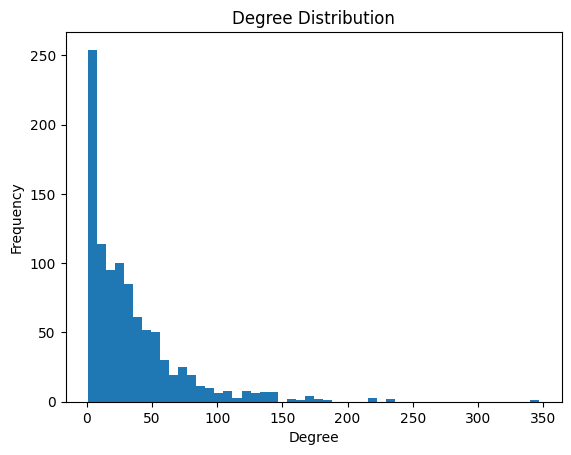

In [10]:
#Linear Scale Histogram
plot.degree_count_plot(G_lcc, logy=False)

This histogram, plotted on a linear scale, reveals a highly skewed distribution with a "long tail." The vast majority of nodes have low degrees, while a few "hub" nodes possess a disproportionately high number of connections. This pattern is characteristic of a power law.

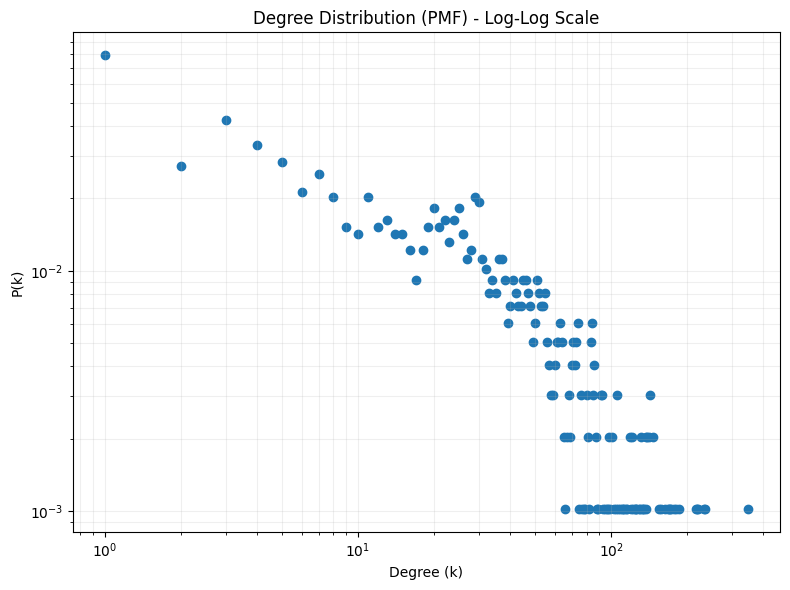

In [11]:
# Log-Log Scale Probability Mass Function (PMF)
plot.degree_distribution_plot(G_lcc)

On the log-log scale, the degree distribution exhibits a linear trend for lower to mid-range degrees, which is indicative of power-law behavior. However, the clear deviation  observed at higher degrees suggests the network is not a pure power-law across its entire range. 

Consequently, Preferential Attachment performance in a link prediction task could be limited or not optimal, particularly for links involving high-degree nodes where the power-law assumption is invalid (added to the near-zero value for assortativity measured before).

## Classifiers Comparison